<a href="https://colab.research.google.com/github/cosimo-schiavoni/Massive_Data_Project/blob/main/Comics_Faces_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check the connection to a GPU.

In [1]:
!nvidia-smi

Thu Sep  1 14:02:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install the Kaggle package.

In [2]:
!pip install -q kaggle

Load the kaggle.json file in order to execute the download of the dataset. (Each user should upload his own file).

In [3]:
from google.colab import files

files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Import required libraries.

In [105]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers
from functools import reduce
import os
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import pickle
import shutil
import random
import skimage.io as io
from copy import deepcopy
from kaggle.api.kaggle_api_extended import KaggleApi
from tensorflow.keras import layers
import numpy as np

Download the dataset from a remote repository.

In [106]:
os.environ["data_source"] = "./Face_Comics_data"

api = KaggleApi()
api.authenticate()

if not os.path.exists(os.environ["data_source"]):
  os.makedirs(os.environ["data_source"])
  if "comic-faces-paired-synthetic-v2" not in os.listdir():
    if "comic-faces-paired-synthetic-v2.zip" not in os.listdir():
      ! kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2
      with zipfile.ZipFile("comic-faces-paired-synthetic-v2.zip", 'r') as f:
        f.extractall("comic-faces-paired-synthetic-v2")
    os.remove("comic-faces-paired-synthetic-v2.zip")


!mv "./comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics" "./Face_Comics_data"
!mv "./comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces" "./Face_Comics_data"

!rm -rf comic-faces-paired-synthetic-v2

mv: cannot stat './comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics': No such file or directory
mv: cannot stat './comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces': No such file or directory


Define data augmentation functions to be implemented in the analysis.

In [107]:
#data augmentation

@tf.function
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (180-x)
  else:
    x
  return x

###Randim invert
@tf.function 
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

#@tf.function 
class RandomInvert(layers.Layer):
  @tf.function 
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor
  @tf.function 
  def call(self, x):
    return random_invert_img(x)


###Kernel Inizializer Sobel_x
@tf.function 
def hedge_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [-5, -4, 0, 4, 5], 
            [-8, -10, 0, 10, 8], 
            [-10, -20, 0, 20, 10], 
            [-8, -10, 0, 10, 8], 
            [-5, -4, 0, 4, 5]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (5, 5, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

@tf.function 
def vertical_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [1, 0, -1], 
            [1, 0, -1], 
            [1, 0, -1]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (3, 3, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

@tf.function 
def horizontal_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [1, 1, 1], 
            [0, 0, 0], 
            [-1, -1, -1]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (3, 3, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

Define the CNN model, the Training and the Validation dataset. 

In [108]:
###Create CNN
##Initialize the CNN
cnn = tf.keras.models.Sequential()
      
cnn.add(tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.3),
  layers.RandomContrast(0.5, seed=None),
  RandomInvert(),
  layers.RandomZoom(height_factor=(-0.2, +0.3)),
  layers.RandomTranslation(height_factor=(-0.2, +0.3),width_factor=(-0.2, +0.3)),
  layers.Rescaling(1./255, offset= -1)
  ]))

#NORMAL
#Convolution
cnn.add(tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, activation='relu',  input_shape = [350,350,3]))
#Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
#Convolution
cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu'))
#Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
#Second Convolutional Layer
cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2,  strides=2, activation = 'relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=1, padding='same'))
#Flattening
cnn.add(tf.keras.layers.Flatten())
#Full Connection
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
#Output Layer
cnn.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))

###Training CNN
##Compiling the CNN
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mse'])



def get_dataset():
    BUFFER_SIZE = 10000

    BATCH_SIZE_PER_REPLICA = 64
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

    data_dir= "./Face_Comics_data"

    tf.random.set_seed(123456)

    EPOCHS = 15
    IMG_SIZE = (350, 350)

    os.listdir(data_dir)


    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="training",
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)


    validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.4,
        subset="validation",
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)
    
    val_batches = tf.data.experimental.cardinality(validation_dataset)
    test_dataset = validation_dataset.take(val_batches // 5)
    validation_dataset = validation_dataset.skip(val_batches // 5)
    print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
    print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
    print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

    AUTOTUNE = tf.data.AUTOTUNE

    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

    return (
        train_dataset,
        validation_dataset,
        test_dataset
    )




Alternative models can be substituted to the Normal one.

In [ ]:

"""------------------------------------ DROPOUT --------------------------------------------------


    #Convolution
    cnn.add(tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, activation='relu',  input_shape = [350,350,3]))
    #Pooling
    cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu'))
    #Pooling
    cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Second Convolutional Layer
    cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2,  strides=2, activation = 'relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=1, padding='same'))
    #Flattening
    cnn.add(tf.keras.layers.Flatten())
        #Full Connection
    cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    #DROPOUTS ok(0.1)
    cnn.add(tf.keras.layers.Dropout(0.1))
    #Output Layer
    cnn.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))
"""

"""------------------------------------ L1 --------------------------------------------------
    #######L1

    #Introduce the Convolution layer with Kernel_initializer=Sobel_x
    #Convolution
    cnn.add(tf.keras.layers.Conv2D(32, kernel_size=5, kernel_initializer = hedge_detector, strides=2, activation='relu',  input_shape = [350,350,3]))
    #Pooling
    cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu',kernel_regularizer =tf.keras.regularizers.l1( l=0.01)))
    #Pooling
    cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Second Convolutional Layer
    cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2,  strides=2, activation = 'relu',kernel_regularizer =tf.keras.regularizers.l1( l=0.01)))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=1, padding='same'))
    #Third Convolutional Layer
    #cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2, activation = 'relu'))
    #cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=2))
    #Flattening
    cnn.add(tf.keras.layers.Flatten())
    #Full Connection
    cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    #Output Layer
    cnn.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))
"""

"""------------------------------------ L2 --------------------------------------------------


    #Introduce the Convolution layer with Kernel_initializer=Sobel_x
    #Convolution
    cnn.add(tf.keras.layers.Conv2D(32, kernel_size=5, kernel_initializer = hedge_detector, strides=2, activation='relu',  input_shape = [350,350,3]))
    #Pooling
    cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
    #Pooling
    cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Second Convolutional Layer
    cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2,  strides=2, activation = 'relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=1, padding='same'))
    #Third Convolutional Layer
    #cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2, activation = 'relu'))
    #cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=2))
    #Flattening
    cnn.add(tf.keras.layers.Flatten())
    #Full Connection
    cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    #Output Layer
    cnn.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))
"""

Create a Mirrored strategy in order to distribute computation with Tensorflow engine.

In [109]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))


Number of devices: 1


Create a Strategy scope, and put the compiled model inside it.

In [110]:
with strategy.scope():
    model = get_compiled_model()

Train the model on all available devices.

In [111]:
train_dataset, validation_dataset, test_dataset = get_dataset()
model_fit = model.fit(train_dataset, epochs=2, validation_data=validation_dataset)
model_fit

Found 20000 files belonging to 2 classes.
Using 14000 files for training.
Found 20000 files belonging to 2 classes.
Using 8000 files for validation.
Number of training batches: 219
Number of validation batches: 100
Number of test batches: 25
Epoch 1/2
219/219 [==============================] - 110s 465ms/step - loss: 0.6200 - mse: 0.2197 - val_loss: 0.5462 - val_mse: 0.1877
Epoch 2/2
219/219 [==============================] - 103s 463ms/step - loss: 0.5437 - mse: 0.1790 - val_loss: 0.6269 - val_mse: 0.2220


In [112]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_25 (Sequential)  (None, 350, 350, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 173, 173, 32)      2432      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 86, 86, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 42, 42, 32)        9248      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 21, 21, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 10, 10, 32)      

Test the model on all available devices.

In [113]:
stringlist = []
model.summary(line_length=70, print_fn=lambda x: stringlist.append(x))

substring = 'Trainable params'

c = 0
for n in stringlist:
    if substring not in n:
      c += 1
    else:
      break

substring = stringlist[c]  
Model_parameters_n = int("".join([i for i in substring if i.isdigit()]))
Model_parameters_n

425665

In [16]:
mse = model_fit.history['mse']

In [17]:
mse

[0.2268851101398468, 0.17049580812454224]

In [103]:
(14000 * np.log(0.2268851101398468) ) + (2*Model_parameters_n)
(14000 * np.log(0.17049580812454224) ) + (2*Model_parameters_n)


826563.3760432315

In [11]:
model.evaluate(test_dataset)

25/25 [==============================] - 10s 329ms/step - loss: 0.0097 - accuracy: 0.9969


[0.009685798548161983, 0.996874988079071]

Plot the Train and Validation loss and accuracy graph.

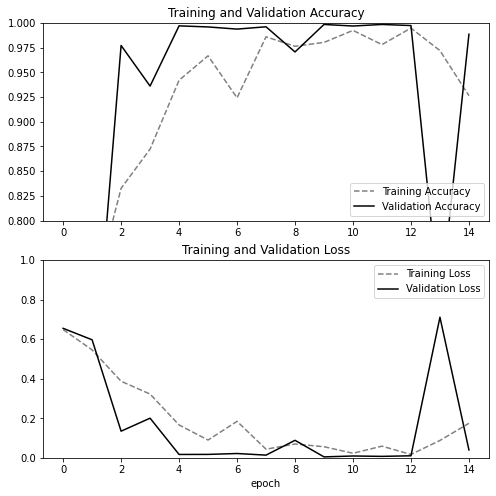

In [ ]:
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
loss_ = model_fit.history['loss']
val_loss_ = model_fit.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color = 'gray',linestyle='dashed')
plt.plot(val_acc, label='Validation Accuracy', color = 'black')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss', color = 'gray',linestyle='dashed')
plt.plot(val_loss_, label='Validation Loss', color = 'black')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
